## Background

In the fastai course Part 1 [Lesson 6 video](https://youtu.be/AdhG64NF76E?feature=shared&t=3117) Jeremy Howard walked through the notebooks [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) where he builds increasingly accurate solutions to the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) Kaggle Competition. In the video, Jeremy referenced a series of walkthrough videos that he made while working through the four-notebook series for this competition. I'm excited to watch these walkthroughs to better understand how to approach a Kaggle competition from the perspective of a former #1 Kaggle grandmaster.

In this blog post series, I'll walk through the code Jeremy shared in each of the 6 Live Coding videos focused on this competition, submitting predictions to Kaggle along the way. My last two blog posts in this series reference Jeremy's [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3) notebook to improve my large model ensemble predictions. Here are the links to each of the blog posts in this series:

- [Part 1: Live Coding 8](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-1/)
- [Part 2: Live Coding 9](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-2/)
- [Part 3: Live Coding 10](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/)
- [Part 4: Live Coding 11](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-4/)
- [Part 5: Live Coding 12](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-5/)
- [Part 6: Live Coding 13](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-6/)
- Part 7: Improving My Large Ensemble, Part 1 (You are here)
- [Part 8: Improving My Large Ensemble, Part 2](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)


In [ ]:
from google.colab import userdata
creds = userdata.get('kaggle')

In [ ]:
from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [ ]:
!pip install -qq timm==0.6.13
import timm
timm.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 6.5 MB/s eta 0:00:00


'0.6.13'

In [ ]:
import zipfile,kaggle

path = Path('paddy-disease-classification')
if not path.exists():
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 1.02G/1.02G [00:35<00:00, 30.9MB/s]


In [ ]:
from fastai.vision.all import *

In [ ]:
path.ls()

(#4) [Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images')]

In [ ]:
trn_path = path/'train_images'

In [ ]:
# run this once and re-use for all trainings
tst_files = get_image_files(path/'test_images')
tst_files.sort()

In [ ]:
tst_files[:5]

(#5) [Path('paddy-disease-classification/test_images/200001.jpg'),Path('paddy-disease-classification/test_images/200002.jpg'),Path('paddy-disease-classification/test_images/200003.jpg'),Path('paddy-disease-classification/test_images/200004.jpg'),Path('paddy-disease-classification/test_images/200005.jpg')]

## Using `lr_find` for Large Models

One of the students in Live coding 12 faced the same problem as I did: their large model ensemble submission did not improve their Kaggle scores. Jeremy said this is probably because they ran some incorrect code somewhere, and suggested (among other things), to see if using a learning rate from `lr_find` improved their ensemble. This is what I'll try next to improve my Kaggle score. If it doesn't work, I'll reference Jeremy's Road to the Top notebook corresponding to large model training, and see what I coded wrong.

In [ ]:
kwargs = {'bs': 16}
cbs = GradientAccumulation(2)

In [ ]:
arch = 'swinv2_large_window12_192_22k'

I wasn't getting a very promising learning rate result the first few times I rant it. The `lr_find` plot didn't have a section that was steep and somewhat linear, so I'll run `lr_find` a few times here to show what I was seeing:

SuggestedLRs(valley=0.0010000000474974513)

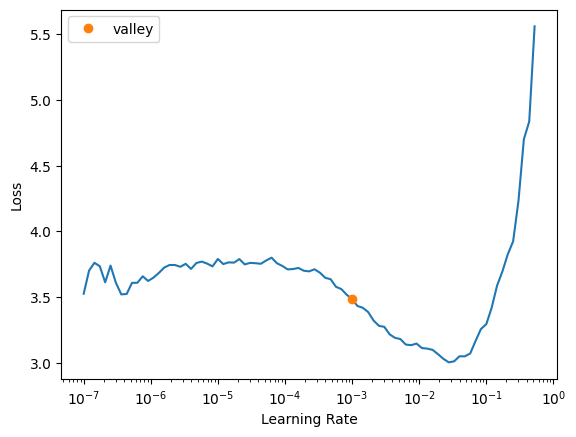

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=192, min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

SuggestedLRs(valley=0.0008317637839354575)

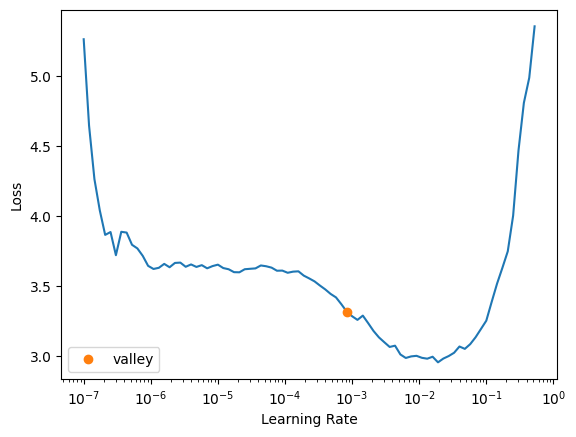

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=192, min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

SuggestedLRs(valley=0.0012022644514217973)

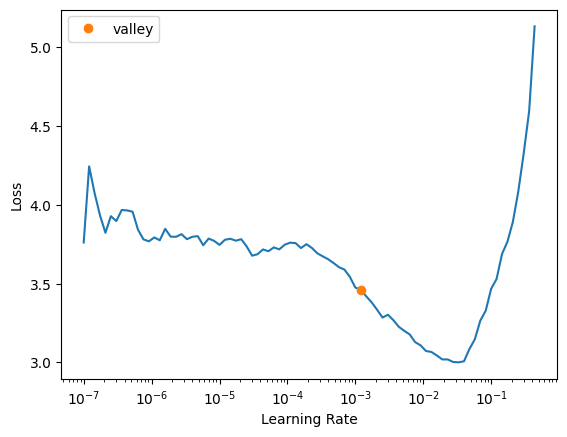

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=192, min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

The suggested learning rate (~0.001) is always conservative, so I'll pick something larger for the swinv2_large_window12_192_22k architecture: 0.005.

In [ ]:
arch = 'convnext_large_in22k'

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


SuggestedLRs(valley=0.0014454397605732083)

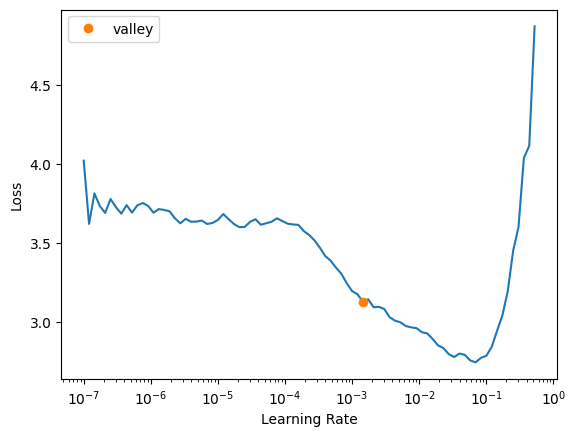

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize((640,480)),
    batch_tfms=aug_transforms(size=(288,224), min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

SuggestedLRs(valley=0.0010000000474974513)

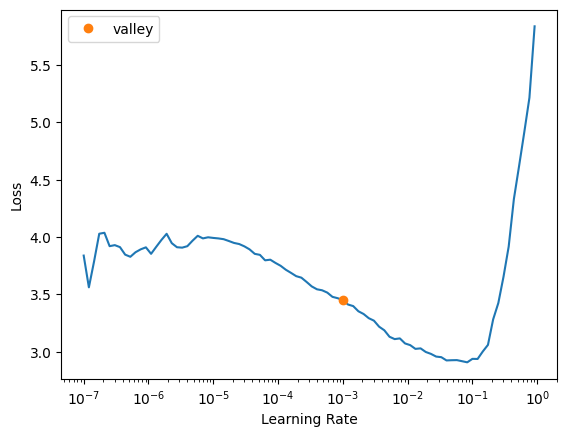

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize((640,480)),
    batch_tfms=aug_transforms(size=(288,224), min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

SuggestedLRs(valley=0.0008317637839354575)

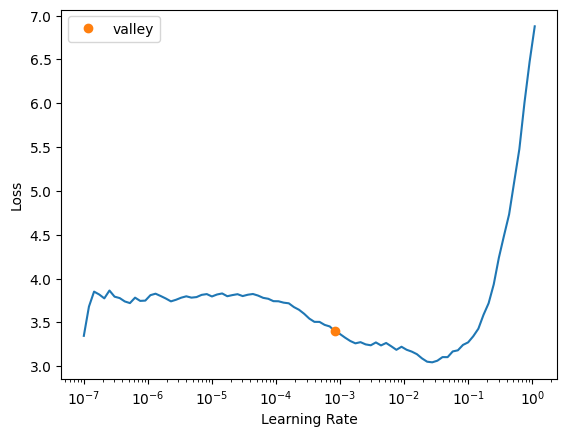

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize((640,480)),
    batch_tfms=aug_transforms(size=(288,224), min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

For convnext_large_in22k, I'm tempted to use 0.02, but in the last run of `lr_find`  the loss just starts to inflect upwards at this learning rate. I'll go with 0.015.

In [ ]:
arch = 'vit_large_patch16_224'

SuggestedLRs(valley=0.0010000000474974513)

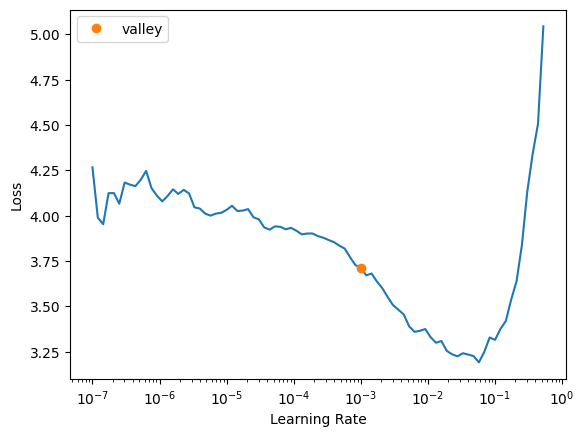

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(480),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

SuggestedLRs(valley=0.0008317637839354575)

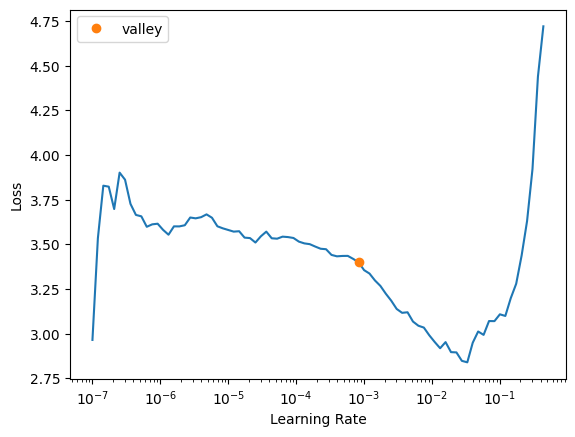

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(480),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

SuggestedLRs(valley=0.00363078061491251)

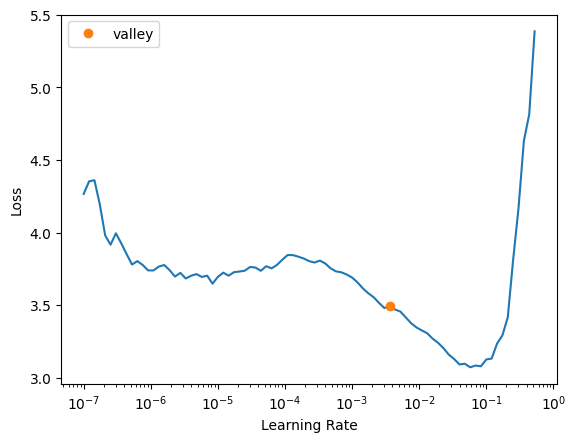

In [ ]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(480),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    **kwargs)

learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
learn.model_dir = '/tmp/model'
learn.lr_find()

For vit_large_patch16_224, I'll use a learning rate of 0.005. I was tempted to use 0.01 but the loss starts to enter instability in the second `lr_find` run.

Here is a summary of learning rates I'll use for each architecture:

|Architecture|Learning Rate|
|:-:|:-:|
|swinv2_large_window12_192_22k|0.005
|convnext_large_in22k|0.015
|vit_large_patch16_224|0.005

In [ ]:
tta_res = []

Note that my `train` function now has the parameters `lr` and `n_epochs` to specify learning rate and number of training epochs, respectively.

In [ ]:
def train(arch, item, batch, lr, n_epochs=24, accum=False):
    kwargs = {'bs': 16} if accum else {}
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch, **kwargs)
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(n_epochs, lr)

    # view losses
    learn.recorder.plot_loss()

    # TTA predictions using test dataset
    tst_dl = dls.test_dl(tst_files)
    tta_res.append(learn.tta(dl=tst_dl))

    # Return error rate using validation dataset
    print(error_rate(*learn.tta(dl=dls.valid)))
    return learn, dls

In [ ]:
def prep_submission(fn, tta_res):
    # pull out predictions from tta_res list
    tta_prs = first(zip(*tta_res))

    # convert tta_res from list to stacked tensor
    t_tta = torch.stack(tta_prs)

    # take mean of each item's predictions
    avg_pr = t_tta.mean(0)

    # get the index (class) of the maximum prediction for each item
    idxs = avg_pr.argmax(dim=1)

    # create DataLoaders to get its vocab
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))

    # convert indexes to vocab strings
    mapping = dict(enumerate(dls.vocab))

    # add vocab strings to sample submission file and export to CSV
    ss = pd.read_csv(path/'sample_submission.csv')
    results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
    ss.label = results
    ss.to_csv(fn, index=False)

In [ ]:
arch = 'swinv2_large_window12_192_22k'

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.070781,0.601547,0.201346,04:03


epoch,train_loss,valid_loss,error_rate,time
0,0.430227,0.230742,0.080250,05:29
1,0.336965,0.175396,0.056704,05:29
2,0.298998,0.187081,0.057665,05:30
3,0.307775,0.166967,0.055742,05:30
4,0.274865,0.170166,0.045651,05:34
5,0.314666,0.183352,0.049976,05:31
6,0.225893,0.139452,0.038924,05:31
7,0.209061,0.147105,0.039885,05:31
8,0.166353,0.107878,0.027871,05:31
9,0.220547,0.132710,0.033638,05:29


epoch,train_loss,valid_loss,error_rate,time
0,0.430227,0.230742,0.080250,05:29
1,0.336965,0.175396,0.056704,05:29
2,0.298998,0.187081,0.057665,05:30
3,0.307775,0.166967,0.055742,05:30
4,0.274865,0.170166,0.045651,05:34
5,0.314666,0.183352,0.049976,05:31
6,0.225893,0.139452,0.038924,05:31
7,0.209061,0.147105,0.039885,05:31
8,0.166353,0.107878,0.027871,05:31
9,0.220547,0.132710,0.033638,05:29


TensorBase(0.0178)


(<fastai.learner.Learner at 0x782e6b00a860>,
 <fastai.data.core.DataLoaders at 0x782e6b00a740>)

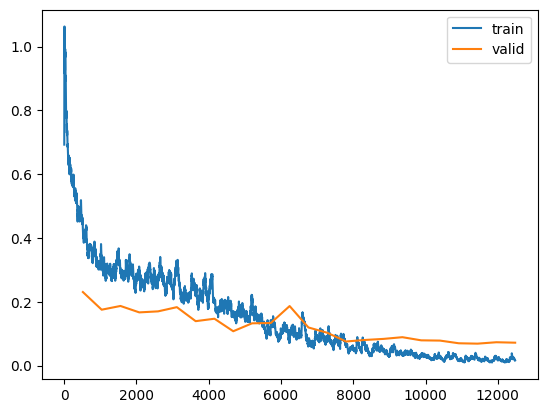

In [ ]:
train(
    arch,
    item=Resize(480, method='squish'),
    batch=aug_transforms(size=192, min_scale=0.75),
    lr=0.005,
    n_epochs=24,
    accum=True)

The output is unfortunately a bit messy, but here are my observations:

- The TTA error rate is 0.0178 and the final epoch's validation error rate is a bit lower. This is a good sign as this shows an improvement in error rate compared to the error rate (0.01862) when using a learning rate of 0.01. However, the improvement is only 5%, which seems unremarkable.
- The training and validation losses look okay. The both decrease over epochs, and the validation loss does not seem to be increasing significantly at the end, so the model is not overfitting.

I'm not convinced that changing the learning rate from 0.01 to 0.005 has significantly improved my model, but I will go ahead and train the other two models in this ensemble and submit the predictions to Kaggle. If the private score does not improve, I'll reference Jeremy's "Road to the Top" notebook series to see how he trained his large models.

In [ ]:
len(tta_res), len(tta_res[0][0])

(1, 3469)

In [ ]:
arch = 'convnext_large_in22k'

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.350656,0.639466,0.192696,03:17


epoch,train_loss,valid_loss,error_rate,time
0,0.393383,0.226754,0.069678,05:01
1,0.278609,0.194963,0.054301,05:00
2,0.258872,0.242242,0.069678,04:59
3,0.272949,0.242155,0.070639,05:01
4,0.250942,0.288342,0.073042,04:59
5,0.256650,0.224654,0.060067,05:00
6,0.215623,0.242569,0.054781,04:59
7,0.204849,0.183193,0.049495,04:59
8,0.175016,0.224864,0.044210,04:58
9,0.179674,0.374226,0.078328,04:58


TensorBase(0.0197)


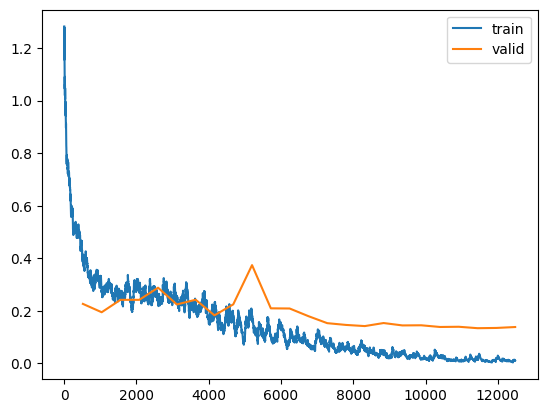

In [ ]:
learn, dls = train(
    arch,
    item=Resize((640,480)),
    batch=aug_transforms(size=(288,224), min_scale=0.75),
    lr=0.015,
    n_epochs=24,
    accum=True)

Here are my observations:

- The larger learning rate of 0.015, although reasonably estimated from the `lr_find` plot, has decreased the performance of the model. The final validation error rate with lr=0.015 is 0.019702, which is larger than the final validation error rate with lr=0.01 (0.014416). I'll stick with this for now---perhaps this difference in validation error rate can be attributed to the difference in validation sets. Again, if my large model ensemble does not result in an improved Kaggle score, I'll reference Jeremy's solution.
- The training and validation losses are generally decreasing over the epochs, and are not showing signs of overfitting (i.e., validation loss increasing).

I'll train the final model next.

In [ ]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0])

(2, 3469, 3469)

In [ ]:
# save_pickle("colab_tta_res.pkl", tta_res)

In [ ]:
# tta_res = load_pickle("colab_tta_res.pkl")

In [ ]:
arch = 'vit_large_patch16_224'

epoch,train_loss,valid_loss,error_rate,time
0,1.163018,0.609755,0.195579,04:13


epoch,train_loss,valid_loss,error_rate,time
0,0.495968,0.220330,0.067756,06:21
1,0.365600,0.222172,0.073522,06:22
2,0.306510,0.231306,0.064873,06:22
3,0.312357,0.164647,0.044690,06:21
4,0.326301,0.223919,0.060548,06:21
5,0.291703,0.213934,0.057665,06:21
6,0.221403,0.221377,0.055262,06:18
7,0.234319,0.178601,0.044690,06:19
8,0.171401,0.246879,0.049976,06:18
9,0.194408,0.148840,0.035079,06:18


TensorBase(0.0139)


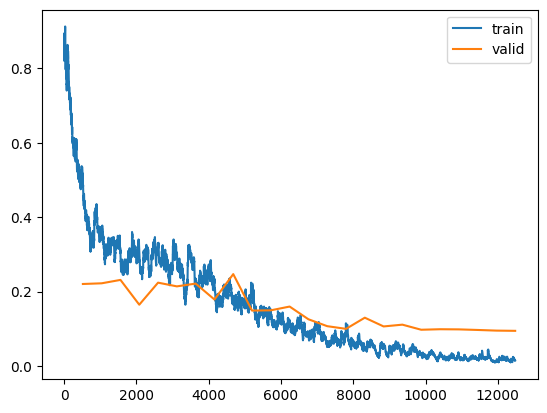

In [ ]:
learn, dls = train(
    arch,
    item=Resize(480),
    batch=aug_transforms(size=224, min_scale=0.75),
    lr=0.005,
    n_epochs=24,
    accum=True)

In [ ]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0])

(3, 3469, 3469, 3469)

Observations about this training:

- The final validation error rate for lr=0.005 was 0.014416, which is about 35% less than when lr=0.01 (0.02215). That's a good sign that this smaller learning rate was a better choice.
- As with the other models, the training and validation losses generally decrease over epochs.

In [ ]:
# save_pickle("final_tta_res.pkl", tta_res)

.

In [ ]:
# tta_res = load_pickle("final_tta_res.pkl")

I'll make a new submission with these predictions to Kaggle and see how it scores:

In [ ]:
prep_submission("subm.csv", tta_res)

In [ ]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


The submission's first few values are the same as before, so that's a good sign.

This submission's scores were:

- Private: 0.98387 (previous best: 0.98617)
- Public: 0.98577 (previous best: 0.98577)

The submissions with the best private score are still my small ensemble of these architectures that were trained for 12 epochs, and a large ensemble with the vit predictions with 3x the weight of the others.

I'll triple the weight of the large vit model predictions and submit it to Kaggle to see if it improves the private score:

In [ ]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0])

(3, 3469, 3469, 3469)

In [ ]:
tta_res += 2 * [tta_res[2]]

In [ ]:
len(tta_res), len(tta_res[0][0]), len(tta_res[1][0]), len(tta_res[2][0]), len(tta_res[3][0]), len(tta_res[4][0])

(5, 3469, 3469, 3469, 3469, 3469)

In [ ]:
prep_submission("subm.csv", tta_res)

In [ ]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This submission matched my previous best Private score, and improved upon my previous best Public score:

- Private score: 0.98617
- Public score: 0.98654

It's interesting to me that I can't break this ceiling of 0.98617! I will now reference Jeremy's large model ensemble and see if I can improve my score by following his methodology in my [next blog post.](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)